#**04장 상점 신용카드 매출 예측 경진대회**

##**4.1 문제 정의**

###**4.1.1 경진대회 소개**

- **목적**:2016.6.1부터 2019.2.28까지의 신용카드 매출 데이터를 가지고 2019.3.1부터 2019.5.31까지의 상점별 3개월 총매출을 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**4.1.2 평가척도**

- **시계열 회귀 분석**
- **MAE**: 실제값과 예측값의 차이에 절댓값을 취하고 평균값을 계산한 손실함수 


####**베이스라인 코드**
- [베이스라인 코드](https://dacon.io/competitions/official/140472/codeshare/1734?page=1&dtype=recent)

###**4.1.3 대회 관련 사전 조사**


**상점 매출을 예측할 때 중요한 도메인**
1. 자영업자
2. 카드사 직원
3. 고객

###**4.1.4 문제 해결을 위한 접근 방식**

In [ ]:
import pandas as pd
import warnings #분석에 문제가 없는 경고 메세지 숨김
warnings.filterwarnings("ignore")

####**드라이브 마운트로 데이터 불러오기**

*   train.csv
*   submission.csv


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/data09/funda_train.csv')
submission=pd.read_csv('/content/drive/MyDrive/data09/submission.csv')

####**데이터 살펴보기**

In [ ]:
train.shape

(6556613, 9)

In [ ]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


####**데이터 변수명과 설명**


1.   store_id : 상점의 고유 아이디(1,967개 상점)
2.   card_id : 사용한 카드의 고유 아이디
3.   card_company : 비식별화된 카드 회사
4.   transacted_date : 거래 날짜
5.   transacted_time : 거래 시간(시:분)
6.   installment_term : 할부 개월 수(포인트 사용시 '60개월+실제 할부 개월')
7.   region : 상점의 지역
8.  type_of_business : 상점의 업종
9.   amount : 매출액(단위 원X)






In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


####**데이터 노이즈**
- 전처리 작업 필요


#####결측값 확인

In [ ]:
train[:5] #region(NaN) 결측값 존재

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


#####데이터 이상치 확인

In [ ]:
train[train['amount']<0] #매출액 음수 값 = 환불 (이상치)

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857
...,...,...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,제주 제주시,기타 주점업,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,제주 제주시,기타 주점업,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,제주 제주시,기타 주점업,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,제주 제주시,기타 주점업,-8571.428571


####**분석 방향**

**상점별 개별적인 시계열 모델 사용**
- 데이터가 시간의 흐름에 따라 발생한 데이터
- 시간에 영향을 받는 관측치
- 사전 도메인에서 고려할 상황 많음

###**4.1.5 분석환경 구축**

#####**시계열 분석 모델 : ARIMA게열 모델**

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns  #데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import statsmodels  #통계분석
import rpy2 #파이썬에서 R객체 사용(R패키지와 함수 지원), 시계열 모델링할 때 R의 forecast, forecastHybrid 패키지 사용
from tqdm import tqdm  #진행표시 바 제공, 반복문 실행시 수행시간 체크
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AR값을 정하기위한 acf,pcaf


##**4.2 데이터 전처리**

###**4.2.1 노이즈 제거**

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

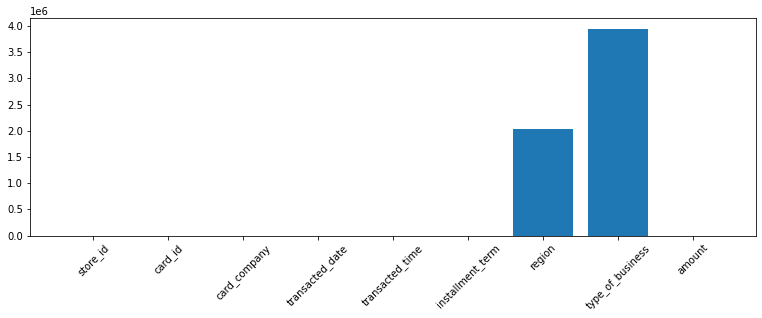

In [ ]:
plt.figure(figsize=(13,4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45) #각도 설정

#지역, 업종에 절반 이상 결측지 존재!!

In [ ]:
#범주형 속성, 대치방법 X -> 열 전체 제거

train =train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


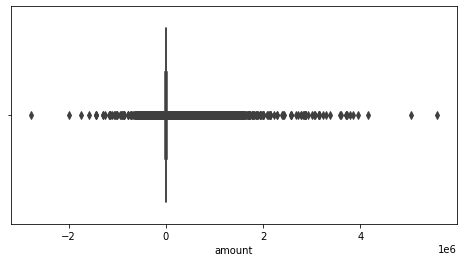

In [ ]:
#매출액 변수 이상치 존재 확인

plt.figure(figsize=(8,4))
sns.boxplot(train['amount'])

#매출액 변수에 음수 존재(환불)

In [ ]:
train[train['amount']<0].head()

#환불 발생일, 환불 발생 시간 이전 데이터 중 카드 아이디가 같고 
#음수 매출액의 절댓값과 양수 매출액이 같은 거래 중 최근 거래 찾아 해당 인덱스 제거

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


In [ ]:
#거래일과 거래시간을 합친 datetime 변수 생성
train['datetime']=pd.to_datetime(train.transacted_date+" "+train.transacted_time,format="%Y-%m-%d %H:%M:%S")
#환불 거래 제거 함수 정의
def remove_refund(df):
  refund=df[df['amount']<0]#매출액 음숫값 데이터 추출(매출액이 0미만인 행)
  non_refund=df[df['amount']>0] #매출액 양숫값 데이터 추출(매출액이 0이상인 행)
  removed_data=pd.DataFrame()
  for i in tqdm(df.store_id.unique()):
  #매출액이 양숫값인 데이터를 상점별로 나눈다.
    divided_data=non_refund[non_refund['store_id']==i]
  #매출액이 음숫값인 데이터를 상점별로 나눈다.
    divided_data2=refund[refund['store_id']==i]

    for neg in divided_data2.to_records()[:]:
      refund_store=neg['store_id']
      refund_id=neg['card_id']#환불 카드 아이디 추출
      refund_datetime=neg['datetime'] #환불 시간 추출
      refund_amount=abs(neg['amount'])#매출 음숫값의 절댓값을 구함

    #환불 시간 이전의 데이터 중 카드 아이디와 환불액이 같은 후보 리스트 뽑음
      refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
      refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
      refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]

    #후보 리스트가 있으면 카드 아이디, 환불액이 같으면서 가장 최근시간을 제거
      if len(refund_pay_list)!=0:
      #가장 최근 시간을 구함
        refund_datetime=max(refund_pay_list['datetime'])
        noise_list=divided_data[divided_data['datetime']==refund_datetime]
      #환불 카드 아이디
        noise_list=noise_list[noise_list['card_id']==refund_id]
      #환불액
        noise_list=noise_list[noise_list['amount']==refund_amount]
      #인덱스를 통해 제거
        divided_data=divided_data.drop(index=noise_list.index)
  #제거한 데이터를 데이터프레임에 추가 
    removed_data=pd.concat([removed_data,divided_data],axis=0)
  return removed_data

100%|██████████| 1967/1967 [13:51<00:00,  2.36it/s]


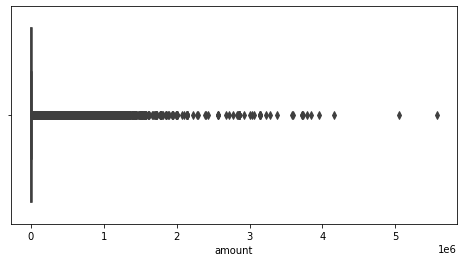

In [ ]:
#환불거래 제거 함수를 통해 환불 거래 제거
positive_data=remove_refund(train)
plt.figure(figsize=(8,4))
sns.boxplot(positive_data['amount'])

#시간이 좀 걸립니다

###**4.2.2 다운 샘플링**
시계열 데이터에서 시간 간격을 넓게 재조정해 데이터 샘플 수 줄이는 것

In [ ]:
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [ ]:
##월별로 다운 샘플링해주는 함수
def month_resampling(df):
    new_data=pd.DataFrame() 
    #년도와 월을 합친 변수 생성
    df['year_month']=df['transacted_date'].str.slice(stop=7)
    #데이터의 전체 기간 추출
    year_month=df['year_month'].drop_duplicates()
    #상점 아이디별로 월 단위 매출액 총합 구함
    downsampling_data=df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        #상점별로 데이터 처리
        store=downsampling_data[downsampling_data['store_id']==i]
        #각 상점의 처으므 매출이 발생한 월 구함
        start_time=min(store['year_month'])
        #데이터를 시간 순으로 정렬
        store=store.merge(year_month,how='outer')
        #매출이 발생하지 않는 월은 2로 채움
        store=store.sort_values(by=['year_month'], axis=0, ascending=True) ##데이터를 시간순으로 정렬
        
        store['amount']=store['amount'].fillna(2)   #매출이 발생하지 않는 월은 2로 채움
        store['store_id']=store['store_id'].fillna(i) #store_id 결측치 채움
        store=store[store['year_month']>=start_time]  #매출 시작일 이후만 뽑음
        
        new_data=pd.concat([new_data,store],axis=0)
        
    return new_data

In [ ]:
#환불 제거 데이터를 월 단위로 다운 샘플링
resampling_data=month_resampling(positive_data)
resampling_data['store_id']=resampling_data['store_id'].astype(int)
resampling_data
#시간 간격이 너무 크거나 작으면 정확도가 떨어짐
# 지속적인 탐색을 통해 적절한 다운 샘플링 시간 간격을 찾는 것이 주요 과제!

100%|██████████| 1967/1967 [00:19<00:00, 101.38it/s]


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06


###**4.2.3 날짜 지정 범위 생성과 시리즈 객체 변환**

In [ ]:
#다운 샘플링한 데이터 타입 데이터프레임 확인
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#상점 아이디별 인덱스에 날짜 지정 범위 생성, 시리즈 객체로 변환
def time_series(df,i):
  #상점 아이디별로 데이터 뽑기
  store=df[df['store_id']==i]
  #날짜 지정 범위는 영업시작 월부터 2019년 3월 전까지 영업 마감일 기준
  #date_range함수로 시리즈 객체의 인덱스에 지정할 날짜 범위 생성
  index=pd.date_range(min(store['year_month']),'2019-03',freq='BM') #주말이 아닌 평일 중 각 달의 마지막 날 기준으로 날짜 생성
  #시리즈 객체로 변환
  ts=pd.Series(store['amount'].values,index=index)
  return ts

In [ ]:
#상점 아이디가 0번인 데이터를 시리즈 객체로 변환 후 출력
store_0=time_series(resampling_data,0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

In [ ]:
#상점 아이디가 1인 데이터를 시리즈 객체로 변환 후 데이터 타입 확인
store_1=time_series(resampling_data,1)
print(type(store_1))

<class 'pandas.core.series.Series'>


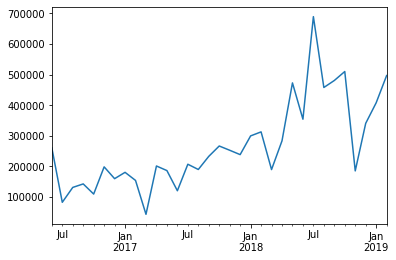

In [ ]:
#상점 아이디가 2번인 데이터를 시리즈 객체로 변환
store_2=time_series(resampling_data,2)
store_2.plot()

#시계열 모델 구축에는 매출액의 변동 계수(매출액 표준편차를 평균으로 나눈 지표)를 고려해 작은 변동을 안정화하는 로그 정규화 진행 예정

###**데이터 전처리 완료**

####1. 노이즈 제거, 다운샘플링을 통해 시계열 모델의 불확실성을 줄이는 작업
####2. 상점별로 날짜 지정 범위 생성, 시리즈 객체 변환

##**4.3 탐색적 데이터 분석**

####**4.3.1 상점별 매출 특성**
- 계절성이 있는 상점
- 추세가 있는 상점
- 휴업 중인 상점

In [ ]:
#계절성이 있는 상점
store_257=time_series(resampling_data,257)
store_257
# 매출이 발생하지 않았던 월은 전부 2로 대치-> 매출액이 2인 월은 매출이 발생하지 않은 월

2016-06-30    4.891857e+05
2016-07-29    1.595280e+06
2016-08-31    1.518714e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    1.557286e+05
2017-06-30    5.481143e+05
2017-07-31    7.359286e+05
2017-08-31    7.909700e+05
2017-09-29    6.191429e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.493857e+05
2018-06-29    4.822286e+05
2018-07-31    8.999714e+05
2018-08-31    1.645877e+06
2018-09-28    2.767857e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

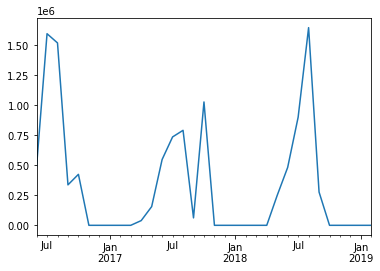

In [ ]:
store_plot_257=store_257.plot()
fig=store_plot_257.plot()
#겨울 시즌(11-3월)에는 매출액이 낮고 여름 시즌(7-8월)에 많은 매출 기록

In [ ]:
store_2096=time_series(resampling_data,2096)
store_2096

2016-07-29    5.075429e+04
2016-08-31    9.219543e+05
2016-09-30    4.720786e+05
2016-10-31    5.145714e+05
2016-11-30    1.494286e+05
2016-12-30    1.071686e+06
2017-01-31    1.602857e+06
2017-02-28    1.332143e+06
2017-03-31    2.432143e+05
2017-04-28    3.903143e+06
2017-05-31    1.729500e+06
2017-06-30    4.280214e+06
2017-07-31    1.775714e+06
2017-08-31    7.428571e+05
2017-09-29    1.415714e+06
2017-10-31    1.180714e+06
2017-11-30    4.640000e+05
2017-12-29    1.389729e+06
2018-01-31    2.000000e+00
2018-02-28    8.285714e+05
2018-03-30    7.857143e+05
2018-04-30    6.670429e+06
2018-05-31    1.837286e+05
2018-06-29    3.285714e+06
2018-07-31    9.502857e+05
2018-08-31    3.675200e+06
2018-09-28    1.793886e+06
2018-10-31    4.717743e+06
2018-11-30    7.593600e+06
2018-12-31    1.428571e+06
2019-01-31    4.285714e+05
2019-02-28    1.428571e+06
Freq: BM, dtype: float64

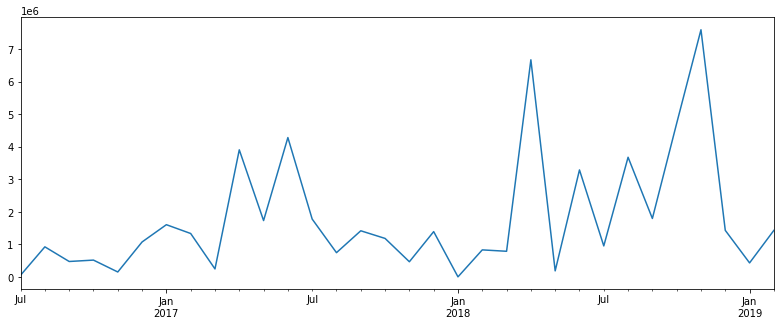

In [ ]:
store_plot_2096=store_2096.plot()
fig=store_plot_2096.get_figure()
fig.set_size_inches(13.5,5)
#겨울 시즌(1-3월)에는 매출액이 낮고 4월에 많은 매출액 상승 패턴

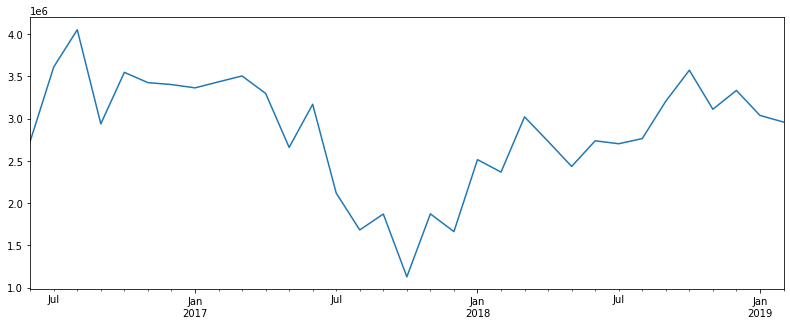

In [ ]:
#추세가 있는 상점
store_335=time_series(resampling_data,335)
store_plot_335=store_335.plot()
fig=store_plot_335.get_figure()
fig.set_size_inches(13.5,5)
#2016년 6월-2017년 10월 감소 추세, 2017년 11월-2019년 2월 증가 추세

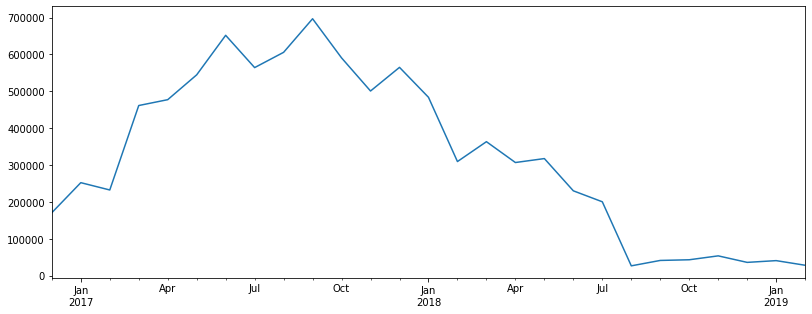

In [ ]:
store_510=time_series(resampling_data,510)
store_plot_510=store_510.plot()
fig=store_plot_510.get_figure()
fig.set_size_inches(13.5,5)
#2016년 12월-2017년 8월 증가 추세, 2017년 9월 이후 감소 추세

In [ ]:
#휴업 중인 상점
store_111=time_series(resampling_data,111)
store_111

2016-06-30    812428.571429
2016-07-29    391142.857143
2016-08-31     13071.428571
2016-09-30    495714.285714
2016-10-31    182714.285714
2016-11-30    178571.428571
2016-12-30     43005.714286
2017-01-31         2.000000
2017-02-28      5428.571429
2017-03-31     24857.142857
2017-04-28    108000.000000
2017-05-31    459142.857143
2017-06-30    137571.428571
2017-07-31    216285.714286
2017-08-31     77000.000000
2017-09-29     78005.714286
2017-10-31         2.000000
2017-11-30         2.000000
2017-12-29         2.000000
2018-01-31      1428.571429
2018-02-28    309785.714286
2018-03-30    259071.428571
2018-04-30    225858.571429
2018-05-31    105571.428571
2018-06-29         2.000000
2018-07-31    123285.714286
2018-08-31         2.000000
2018-09-28     83000.000000
2018-10-31         2.000000
2018-11-30         2.000000
2018-12-31         2.000000
2019-01-31         2.000000
2019-02-28         2.000000
Freq: BM, dtype: float64

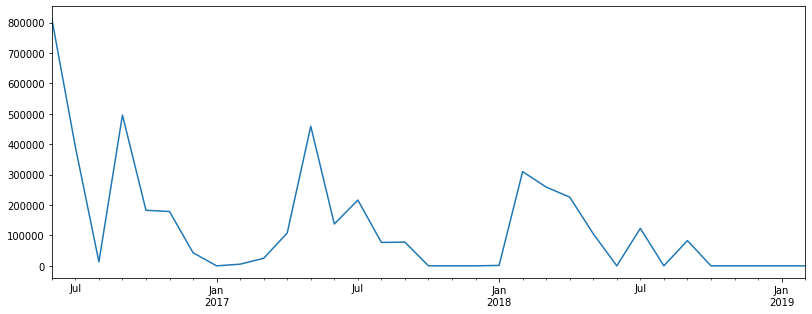

In [ ]:
store_plot_111=store_111.plot()
fig=store_plot_111.get_figure()
fig.set_size_inches(13.5,5)
#2017년 10월-2017년 12얼 휴업, 2019년 10월 이후 휴업 상태 
#2019년 3-5월에는 매출이 발생하지 않을 것으로 예측

In [ ]:
store_279=time_series(resampling_data,279)
store_279

2016-06-30    4.488571e+05
2016-07-29    1.156286e+06
2016-08-31    1.372857e+06
2016-09-30    3.150000e+05
2016-10-31    8.748571e+05
2016-11-30    3.128571e+05
2016-12-30    5.828571e+05
2017-01-31    3.214286e+04
2017-02-28    2.000000e+00
2017-03-31    4.955714e+05
2017-04-28    5.940000e+05
2017-05-31    1.041143e+06
2017-06-30    8.354286e+05
2017-07-31    6.171429e+05
2017-08-31    4.284286e+05
2017-09-29    1.581258e+06
2017-10-31    3.294286e+05
2017-11-30    2.241429e+05
2017-12-29    2.785714e+05
2018-01-31    4.018571e+05
2018-02-28    1.282857e+05
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.000000e+00
2018-06-29    2.000000e+00
2018-07-31    2.000000e+00
2018-08-31    2.000000e+00
2018-09-28    2.000000e+00
2018-10-31    2.000000e+00
2018-11-30    2.101429e+05
2018-12-31    2.191571e+05
2019-01-31    1.779286e+05
2019-02-28    5.157143e+04
Freq: BM, dtype: float64

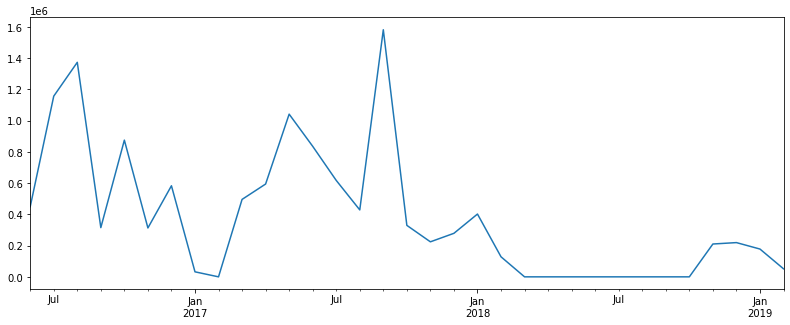

In [ ]:
store_plot_279=store_279.plot()
fig=store_plot_279.get_figure()
fig.set_size_inches(13.5,5)
#2018년 3월-2018년 10월 휴업, 2019년 11월 영업 재개, 2019년 2월 매출 감소 
#2019년 3-5월에는 휴업 예상

####**4.3.2 시계열 데이터의 정상성**
정상성이란?
- 추세나 계절성이 없는 시계열 데이터
- 데이터가 시간의 변동에 따라 평균과 분산이 일정

.
#####시계열 데이터의 정상성을 판단하기 위해 **ADF-Test**사용 
이후 **차분(differencing)**을 통해 비정상 시계열을 평균이 일정한 정상 시계열로 변환하는 작업

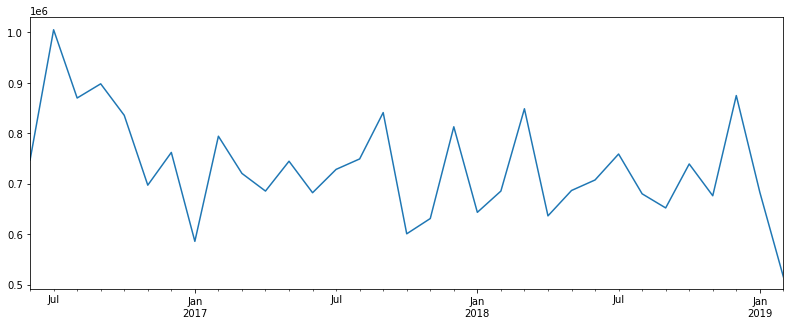

In [ ]:
# 정상 시계열인 0번 상점 시계열 그래프
store_0=time_series(resampling_data,0)
store_plot_0=store_0.plot()
fig=store_plot_0.get_figure()
fig.set_size_inches(13.5,5)
#매출액 시계열의 평균과 분산이 일정

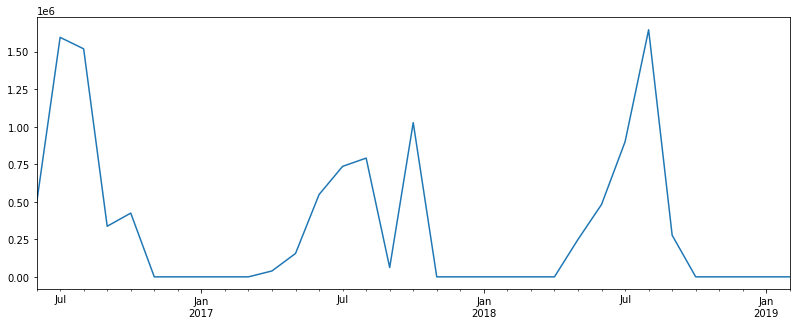

In [ ]:
# 정상 시계열인 257번 상점 시계열 그래프
store_257=time_series(resampling_data,257)
store_plot_257=store_257.plot()
fig=store_plot_257.get_figure()
fig.set_size_inches(13.5,5)
#계절성을 띠고 평균과 분산의 변동 폭이 큼

#####**ADF-Test**
통계학에서 시행하는 가설 검정 절차 따름
- **귀무 가설** : 시계열 자료가 정상 시계열이 아니다.
- **대립 가설** : 시계열 자료가 정상성을 만족한다. 

In [ ]:
'''코랩에서는 pmdarima가 import 되지 않네요. 이 부분은 코드만 한번 봐주세요!

from pmdarima.arima import ADFTest
#pmdarima 패키지에 있는 ADFTest 클래스를 임포트

#상점 아이다가 0번인 데이터를 시리즈 객체로 변환
store_0=time_series(resampling_data,0)
p_val,should_diff=ADFTest().should_diff(store_0)
print('p_val : %f , should_diff : %s' %(p_val,should_diff))

out: 
p_val: 0.022488, should_diff: False

#상점 아이디가 257번인 데이터를 시리즈 객체로 변환
store_257=time_series(resampling_data,257)
p_val,should_diff=ADFTest().should_diff(store_257)
print('p_val : %f , should_diff : %s' %(p_val,should_diff))

out:
p_val: 0.093614, should_diff: True

#should_diff 차분여부 나타냄
#p_val 값이 기준점인 0.05보다 낮으면 대립가설 채택
#p_val 값이 기준점인 0.05보다 높으면 귀무가설 채택 -> 정상시계열이 아니며, 차분이 필요

'''

"코랩에서는 pmdarimam가 import 되지 않네요. 이 부분은 코드만 한번 봐주세요!\n\nFrom pmdarima ARIMA import ADFTest\n#pmdarima 패키지에 있는 ADFTest 클래스를 임포트\n\n#상점 아이다가 0번인 데이터를 시리즈 객체로 변환\nstore_0=time_series(resampling_data,0)\np_val,should_diff=ADFTest().should_diff(store_0)\nprint('p_val : %f , should_diff : %s' %(p_val,should_diff))\n\nout: \np_val: 0.022488, should_diff: False\n\n#상점 아이디가 257번인 데이터를 시리즈 객체로 변환\nstore_257=time_series(resampling_data,257)\np_val,should_diff=ADFTest().should_diff(store_257)\nprint('p_val : %f , should_diff : %s' %(p_val,should_diff))\n\nout:\np_val: 0.093614, should_diff: True\n\n#should_diff 차분여부 나타냄\n#p_val 값이 기준점인 0.05보다 낮으면 대립가설 채택\n#p_val 값이 기준점인 0.05보다 높으면 귀무가설 채택 -> 정상시계열이 아니며, 차분이 필요함\n\n"

In [ ]:
'''
# 1,967개 상점의 ADF_Test의 p-value값을 파이썬의 리스트 자료형에 저장하고 상자그림으로 p-value값 분포 확인
# p-value가 0.05보다 작은 상점 개수 계싼
#매출이 수개월간 발생하지 않은 상점은 ADF-Test가 오류발생해 예외처리

#ARIMA 모델의 차분 여분을 결정하기 위한 단위근 검정
def adf_test(y):
  return ADFTest().should_diff(y)[0]

#전체 상점 adf_test p-value값을 리스트에 저장해 boxplot
adf_p=[]
count=0
skipped=[]
for i in tqdm(resampling_data['store_id'].unique()):
    ts=time_series(resampling_data,i)
    try: 
      p_val = adf_test(ts)
      if p_val < 0.05:
        count+=1
      adf_p.append(p_val)
    except:
      skipped.append(i)
    
plt.figure(figsize=(8, 4))    
sns.boxplot(adf_p)

print(count)

#ADF-Test 오류 상점 개수
if skipped:
  print(f"WarningCount: {len(skipped)},store_id_list{skipped}")
  

#대부분 상점이 기준점인 0.05보다 p-value가 높은 것을 확인
#시계열 모델링을 진행하기 전에 비정상 시계열 자료를 차분을 통해 장상 시계열로 변환
'''

'\n# 1,967개 상점의 ADF_Test의 p-value값을 파이썬의 리스트 자료형에 저장하고 상자그림으로 p-value값 분포 확인\n# p-value가 0.05보다 작은 상점 개수 계싼\n#매출이 수개월간 발생하지 않은 상점은 ADF-Test가 오류발생해 예외처리\n\n#ARIMA 모델의 차분 여분을 결정하기 위한 단위근 검정\ndef adf_test(y):\n  return ADFTest().should_diff(y)[0]\n\n#전체 상점 adf_test p-value값을 리스트에 저장해 boxplot\nadf_p=[]\ncount=0\nskipped=[]\nfor i in tqdm(resampling_data[\'store_id\'].unique()):\n    ts=time_series(resampling_data,i)\n    try: \n      p_val = adf_test(ts)\n      if p_val < 0.05:\n        count+=1\n      adf_p.append(p_val)\n    except:\n      skipped.append(i)\n    \nplt.figure(figsize=(8, 4))    \nsns.boxplot(adf_p)\n\nprint(count)\n\n#ADF-Test 오류 상점 개수\nif skipped:\n  print(f"WarningCount: {len(skipped)},store_id_list{skipped}")\n  \n\n#대부분 상점이 기준점인 0.05보다 p-value가 높은 것을 확인\n#시계열 모델링을 진행하기 전에 비정상 시계열 자료를 차분을 통해 장상 시계열로 변환\n'

##**4.4 모델 구축과 검증**


###**4.4.1 파이썬에서 R시계열 패키지 forecast를 통한 모델링**

In [ ]:
from rpy2.robjects.packages import importr #R 패키지를 import
import rpy2.robjects as robjects  ##R 함수를 쓰기위함
from rpy2.robjects import pandas2ri ##pandas를 R 데이터로 형식으로 변환하기 위함


utils=importr('utils')
utils.install_packages('forecast')
utils.install_packages('forecastHybrid')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/xts_0.12.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 517875 bytes (505 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f13a20123c0> [RTYPES.NILSXP]

In [ ]:
#r의 forecast 패키지를 이용해 상점 아이디가 0번인 상점에 대해 ARIMA모델 예측값 생성 예시
pandas2ri.activate()
auto_arima="""
    function(ts){
      library(forecast)#forecast 패키지 로드 
      d_params=ndiffs(ts)#시계열 자료의 차분 횟수 계산
      model=auto.arima(ts,max.p=2,d=d_params)#auto.arima모델 생성
      forecasted_data=forecast(model,h=3)#이후 3월(h=3)을 예측
      out_df=data.frame(forecasted_data$mean)#예측값을 R의 데이터프레임으로 변환
      colnames(out_df)=c('amount')#amount라는 열로 이름 지정
      out_df
    }
"""

#r()함수로 r자료형을 파이썬에서 사용 가능
auto_arima=robjects.r(auto_arima)
ts=robjects.r('ts')#r자료형 time series자료형으로 만들어주는 함수
c=robjects.r('c')#r자료형 벡터를 만들어주는 함수

store_0=resampling_data[resampling_data['store_id']==0]
start_year=int(min(store_0['year_month'])[:4])#영업 시작 년도
start_month=int(min(store_0['year_month'])[5:])#영업 시작 월

#R의 ts함수로 r의 time series 자료형으로 변환
train=ts(store_0['amount'],start=c(start_year,start_month),frequency=12)

'''
#ensemble model
forecast=auto_arima(train)
np.sum(pandas2ri.ri2py(forecast).values)#3개월 매출을 합산'''

#np.sum(pandas2ri.ri2py(forecast).values)
#ri2py 부분이 작동 되지 않음, 앞에서 pmdarimam도 import 되지 않는 것으로 보아 
#코랩에서 실습하기에 적절하지 않아 보임
# 다른 코드들을 참고하여 다른 방법을 시도해봐야할 것으로 보임



'\n#ensemble model\nforecast=auto_arima(train)\nnp.sum(pandas2ri.ri2py(forecast).values)#3개월 매출을 합산'

###**4.4.2 시계열 모델 선택과 검증**


####**자기회귀누적이동평균(ARIMA) 모델**

        -> AR모델과 MA모델을 섞은 모델
        -> 두 모델을 결합하면 분석의 정확도 상승, 수식 쉽게 결합
        -> 시계열 데이터가 정상성인 경우 주로 적용
        -> 초기 차분 단계를 한 번 이상 적용해 비정상성 제거

    AR모델: 자기회귀 모델(자신의 이전 관측값이 자신의 이후 관측값에 영향을 주는 모델
    MA모델: 이동평균 과정(현재 시계열 데이터가 과거 잔차들의 가중평균으로 구성)



In [ ]:
final_pred=[]

for i in tqdm(resampling_data.store_id.unique()):
    pred=[]
    
    store=resampling_data[resampling_data['store_id']==i]
    start_year=int(min(store['year_month'])[:4]) ##영업 시작 년도
    start_month=int(min(store['year_month'])[5:]) ##영업 시작 월
    #R의 ts함수로 time series데이터로 변환
    train=ts(store['amount'],start=c(start_year,start_month),frequency=12)
    #자동회귀누적이동평균 model
    forecast=auto_arima(train)

    
    #3월 매출을 합산, final_pred에 추가
    # final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))


  0%|          | 0/1967 [00:00<?, ?it/s]R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: This is forecast 8.14 
  Stackoverflow is a great place to get help on R issues:
  http://stackoverflow.com/tags/forecasting+r.

100%|██████████| 1967/1967 [04:37<00:00,  7.08it/s]


#####**지수평활법**
- 단순 지수평활법 
          -> 가장 최근 관측값 가장 중요하게 생각
          -> 이전의 모든 관측값은 미래를 예측할 때 아무런 정보도 주지 않는다고 가정
          -> 미래 예측할때 가장 최근에 관측된 값에 더 많은 가중치
          -> 추세나 계절성이 없을 때 주로 사용
- 홀트의 선형추세 기법
          ->추세가 있는 데이터 예측
          -> 단순 지수평활법 확장
          ->예측식과 두개의 평활식 포함
          

#####**STL 분해를 적용한 지수평활법**
          -> 시계열 데이터가 가진 시간 주기를 알고 있는 경우 시계열 데이터를 계절성과 추세, 나머지 성분으로 분해해 분석하는 기법
          -> STL(실제 관측값= 취세+계절성+나머지 성분) 분해 이유: 매출의 전반적인 트렌드, 계절성 등을 고려해야 정확한 모델을 만들 수 있음

##**4.5 성능 향상을 위한 방법**
- 데이터 전처리를 통한 성능 향상
- 여러 모델을 결합해서 예측을 시도하는 앙상블
   


###**4.5.1 상점 매출액의 로그 정규화**
- 매출액의 작은 변동을 안정화해 더 큰 트렌드 파악하기 위해

###**4.5.2 파이썬에서 R시계열 패키지 forecastHybird를 통한 앙상블**
- 자기회귀누적이동평균 모델, 지수평활법, STL분해를 적용한 지수평활법으로 3개의 예측치 생성
-평균값을 구해 최종 매출액 계산

##**정리**

- 대회 참가하기전 경진대회와 관련된 사전 도메인 공부 추천
<hr>
- 관련 논문 리뷰, 관련 분야 전문가 인터뷰를 통해 사전 도메인을 알면 데이터 전처리와 파생 변수 생성, 모델 적용 과정 훨씬 수월
<hr>
- [데이콘 코드 공유](https://dacon.io/competitions/official/140472/codeshare/?page=2&dtype=recent&ptype=pub) 다른 코랩으로 잘 실행되지 않는 코드들이 있으므로 베이스라인과 참가자들의 코드도 확인하여 작성해보길 추천 & 수상자의 코드 설명 영상 참고 
<hr>

